# Imports

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import setup_multi_gpus, create_corr_matrix, reduce_memory, resample_df, df_to_lstm_format

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

In [68]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

Amount of GPUs available: 4


# Load data

In [69]:
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed/all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'H', combine_all_dwellings=True)

#df['year'] = df.index.year
#df['month'] = df.index.month
#df['day'] = df.index.day
#df['hour'] = df.index.hour #create column containing the hour
#df['dayofweek'] = df.index.dayofweek
#df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)


In [70]:
df.head()

,ePower,ePowerReturn,DD,DR,FF,FX,N,P,Q,RG,SQ,T,T10,TD,U,VV,WW,gasPower,dwelling
datetime,,,,,,,,,,,,,,,,,,,
2017-02-22 12:00:00,87.033333,0.0,240.149994,0.0,11.266666,16.063334,6.000000,1006.333313,90.166664,0.000000,0.0,10.233334,10.100000,8.216666,86.833336,14500.000000,2.000000,1.001953,All dwellings
2017-02-22 13:00:00,92.240356,0.0,236.633331,464.0,10.581667,15.056667,6.833333,1006.016663,71.333336,0.200000,0.0,9.966667,9.733334,8.400000,89.500000,11551.666992,63.333332,0.000000,All dwellings
2017-02-22 14:00:00,93.821724,0.0,234.149994,196.0,10.683333,15.986667,7.833333,1005.483337,91.500000,0.033333,0.0,9.700000,9.550000,8.516666,92.000000,11733.333008,48.500000,0.000000,All dwellings
2017-02-22 15:00:00,133.030640,0.0,237.500000,190.0,11.036667,16.288334,7.666667,1004.983337,51.500000,0.050000,0.0,9.700000,9.550000,8.500000,91.833336,12416.666992,49.000000,0.000000,All dwellings
2017-02-22 16:00:00,111.652779,0.0,237.649994,562.0,10.688334,14.911667,7.666667,1004.650024,26.833334,0.616667,0.0,9.566667,9.300000,8.533334,92.833336,7686.666504,71.166664,0.769043,All dwellings


Saving heatmap


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 576x396 with 0 Axes>

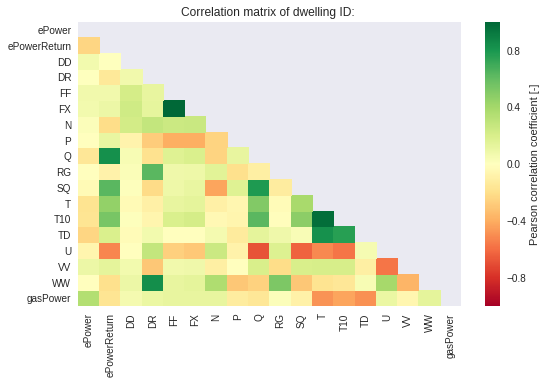

In [71]:
fig = create_corr_matrix(df, '', False)

# Select data to use

Saving heatmap
Len of data:  6584


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 576x396 with 0 Axes>

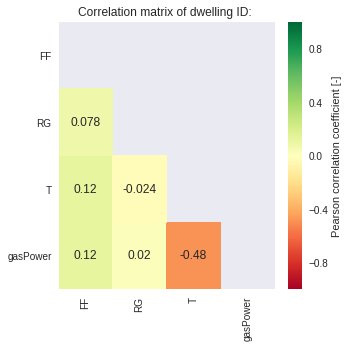

In [72]:
data = df
#data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'dwelling'], axis=1) # Not needed
data = data.drop(['dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower

# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

fig = create_corr_matrix(data, '', True, size=(5,5))

print('Len of data: ', len(data))

(array([736389., 736420., 736450., 736481., 736511., 736542., 736573.,
        736603., 736634., 736664.]), <a list of 10 Text xticklabel objects>)

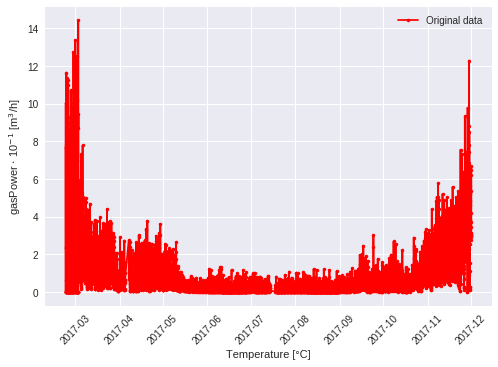

In [73]:
plt.plot(data.index, data['gasPower'], '.-', color='r', label='Original data')
plt.xlabel('Temperature [°C]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.legend()
plt.xticks(rotation=45)

# Preprocessing

In [74]:
"""
Add a copy of gasPower column, so previous gasPower values are also in X_reshaped
"""
data['gasPower_copy'] = data['gasPower']
data.head()

,FF,RG,T,gasPower,gasPower_copy
datetime,,,,,
2017-02-22 12:00:00,11.266666,0.000000,10.233334,10.019531,10.019531
2017-02-22 13:00:00,10.581667,0.200000,9.966667,0.000000,0.000000
2017-02-22 14:00:00,10.683333,0.033333,9.700000,0.000000,0.000000
2017-02-22 15:00:00,11.036667,0.050000,9.700000,0.000000,0.000000
2017-02-22 16:00:00,10.688334,0.616667,9.566667,7.690430,7.690430


# Preprocessing, data to lstm format

In [75]:
look_back = 5*24 # D -> 5
num_features = data.shape[1] - 1
output_dim = 1
test_size = 0.5

X_train, y_train, X_test, y_test = df_to_lstm_format(df=data, test_size=test_size, look_back=look_back, target_column='gasPower', scale_X=True)

In [76]:
def abs_percentage_error(y_true, y_pred):
    import keras.backend as K
    """
    Returns the absolute value of the difference between y_true and y_pred (in percentage).
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

In [77]:
hidden_nodes = 35 # 35

# Create model
model = Sequential()

model.add(LSTM(hidden_nodes, input_shape=(look_back, num_features), kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())
#model.add(Dropout(0.5))

#model.add(Dense(35, kernel_initializer='TruncatedNormal'))
#model.add(LeakyReLU())

#N = 128 #45  
#for i in range(4):
#    model.add(Dense(N-i*4, kernel_initializer='TruncatedNormal'))
#    model.add(LeakyReLU())
    #model.add(Dropout(0.5))


model.add(Dense(units=output_dim, kernel_initializer='TruncatedNormal'))
#model.add(Activation('linear'))

model = multi_gpu_model(model, gpus=num_gpu)

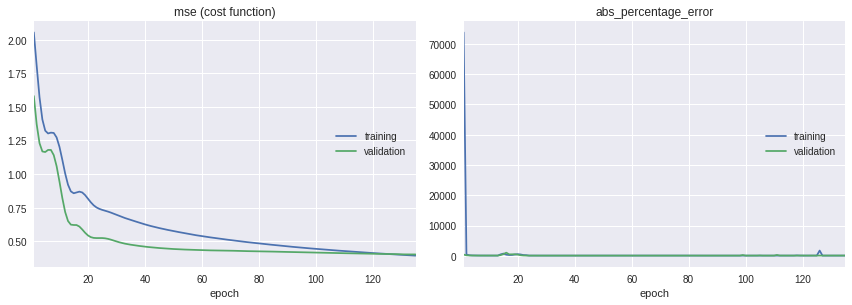

 - 1s - loss: 0.3926 - abs_percentage_error: 57.6468 - val_loss: 0.4016 - val_abs_percentage_error: 88.3887
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_2_input (InputLayer)       (None, 120, 4)       0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 120, 4)       0           lstm_2_input[0][0]               
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 120, 4)       0           lstm_2_input[0][0]               
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 120, 4)       0           lstm_2_input[0][0]               
_

In [78]:
"""
Look back , 5
nodes, 35

More only makes the model more complex and harder/slower to train
"""

epochs = 135 #135

sgd = SGD(lr=0.05, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower

# compile & fit
model.compile(optimizer=sgd, loss = ['mse'], metrics=[abs_percentage_error])


early_stopping_monitor = EarlyStopping(patience=5000)



model.fit(X_train, y_train, epochs=epochs, batch_size=int(len(X_train)/1), validation_data=(X_test, y_test),
         verbose=2, callbacks=[PlotLossesKeras(), early_stopping_monitor])

print(model.summary())

# Create plot

In [80]:
y_preds = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it


3172/3172 [==============================] - 4s 1ms/step
FINISHED


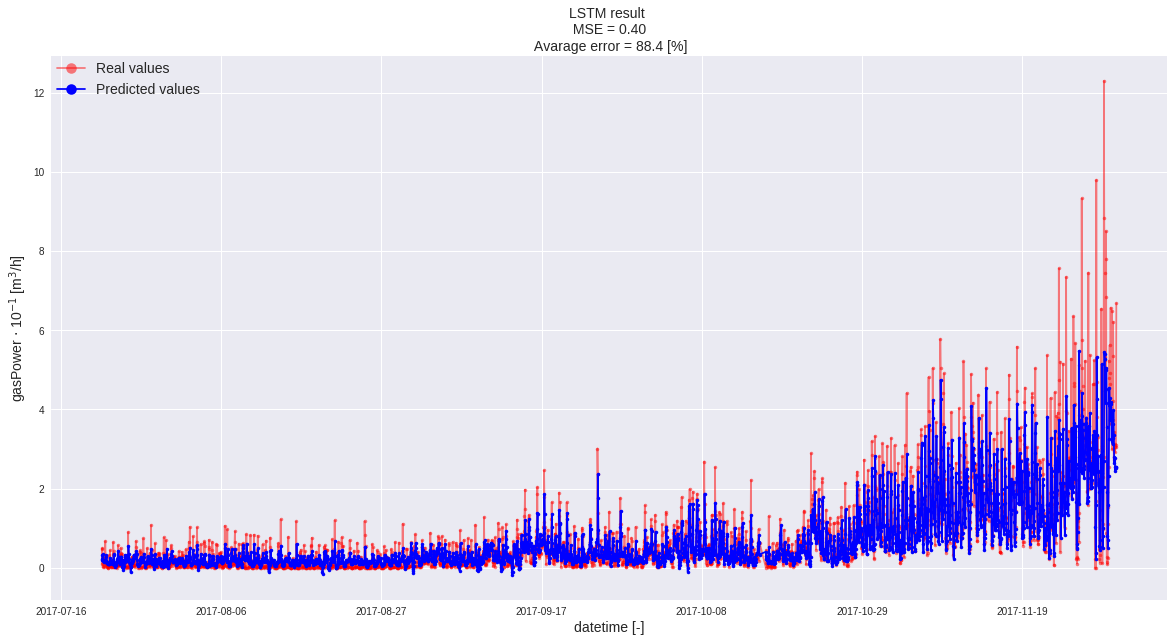

In [85]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='r', label='Real values', alpha=0.5)
plt.plot(x.index, y_preds, '.-', color='b', label='Predicted values')

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse = model.evaluate(X_test, y_test)[0]
perc = model.evaluate(X_test, y_test)[1]

plt.title('LSTM result \n MSE = %.2f \n Avarage error = %.1f [%%]' % (mse, perc), fontsize = 14)

#plt.savefig('figures/LSTM result hourly.png', dpi=300)
print('FINISHED')

# Make the same plot, but downsample the results to a day

In [86]:
# Get results, put it in a dataframe

y_preds = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

# Make it a df to be able to downsample
datetime = x.index
print(datetime.shape)

y_preds = y_preds.reshape(y_preds.shape[0])
y_true = y_true.reshape(y_true.shape[0])

results = pd.DataFrame(y_true, y_preds) # For some reason y_true becomes the index
result = results.reset_index() # Ugly way to fix above problem
result.columns = ['y_pred', 'y_true']

result['datetime'] = datetime
result = result.set_index(['datetime'])

result = result.resample('D').sum() # Resample data

result = result.dropna()

(3172,)


In [87]:
# Calculate the mean abs percentage difference

result['perc_diff'] = (np.abs(result['y_true'] - result['y_pred']) / np.abs(result['y_pred'])) * 100
perc_diff_mean = result['perc_diff'].mean()
perc_diff_std = result['perc_diff'].std()

print('perc diff mean: %.2f \t std: %.2f' % (perc_diff_mean, perc_diff_std))

result.head()

perc diff mean: 16.94 	 std: 14.39


,y_pred,y_true,perc_diff
datetime,,,
2017-07-21,3.350800,3.311267,1.179786
2017-07-22,3.725694,2.970531,20.269040
2017-07-23,4.118794,3.682488,10.593036
2017-07-24,4.834907,3.135367,35.151441
2017-07-25,5.129634,3.876665,24.426098


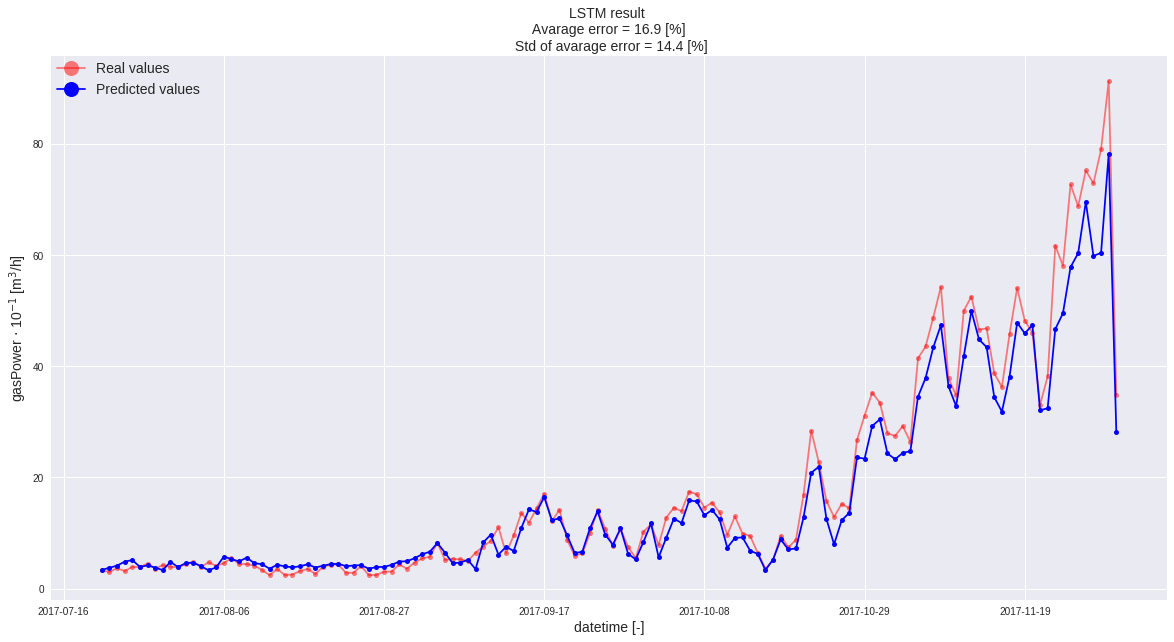

In [88]:
# Create plot
plt.figure(figsize=(20,10))
plt.plot(result.index, result['y_true'], '.-', color='r', label='Real values', alpha=0.5, ms=10) # ms is markersize
plt.plot(result.index, result['y_pred'], '.-', color='b', label='Predicted values', ms=10)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

plt.title('LSTM result \n Avarage error = %.1f [%%] \n Std of avarage error = %.1f [%%]' % (perc_diff_mean, perc_diff_std), fontsize = 14)

plt.savefig('figures/LSTM result hourly resampled to daily by sum.png', dpi=300)

# Try the same with seq2seq

In [95]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from livelossplot import PlotLossesKeras

## Setup variables

In [96]:
layers = [35, 35]
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

## Create encoder

In [97]:
# Define an input sequence.
encoder_inputs = keras.layers.Input(shape=(None, num_features))

# Create a list of RNN Cells, these are then concatenated into a single layer
# with the RNN layer.
encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser,
                                              kernel_initializer='TruncatedNormal'))

encoder = keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

# Discard encoder outputs and only keep the states.
# The outputs are of no interest to us, the encoder's
# job is to create a state describing the input sequence.
encoder_states = encoder_outputs_and_states[1:]

## Create decoder

In [98]:
# The decoder input will be set to zero (see random_sine function of the utils module).
# Do not worry about the input size being 1, I will explain that in the next cell.
decoder_inputs = keras.layers.Input(shape=(None, 1))

decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser,
                                             kernel_initializer='TruncatedNormal'))

decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

# Set the initial state of the decoder to be the ouput state of the encoder.
# This is the fundamental part of the encoder-decoder.
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# Only select the output of the decoder (not the states)
decoder_outputs = decoder_outputs_and_states[0]

# Apply a dense layer with linear activation to set output to correct dimension
# and scale (tanh is default activation for GRU in Keras, our output sine function can be larger then 1)
decoder_dense = keras.layers.Dense(output_dim,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)

decoder_outputs = decoder_dense(decoder_outputs)

## Create model and compile

In [99]:
# Create a model using the functional API provided by Keras.
# The functional API is great, it gives an amazing amount of freedom in architecture of your NN.
# A read worth your time: https://keras.io/getting-started/functional-api-guide/ 
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

sgd = SGD(lr=0.05, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower


model.compile(optimizer='adam', loss='mse', metrics=['mse', abs_percentage_error])

## Fit model

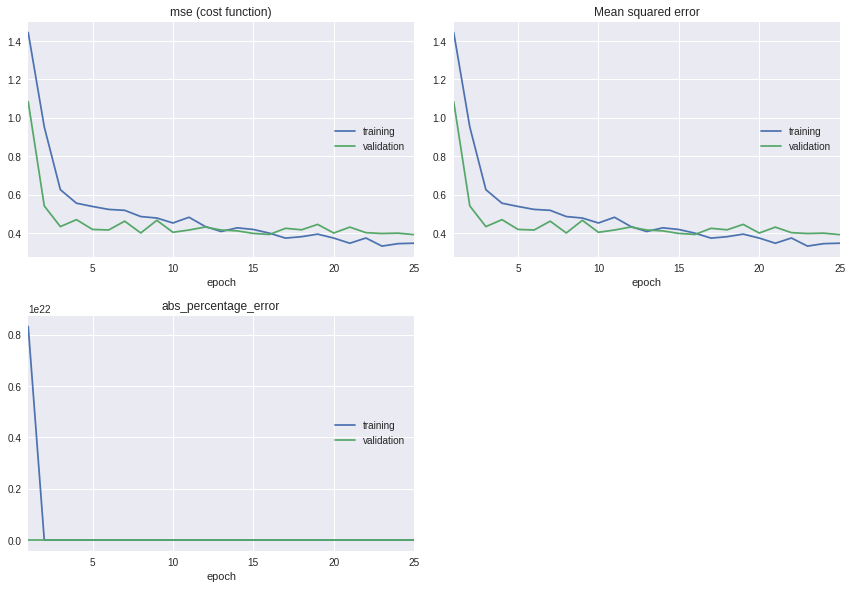

 - 49s - loss: 0.3476 - mean_squared_error: 0.3476 - abs_percentage_error: 70.7076 - val_loss: 0.3922 - val_mean_squared_error: 0.3922 - val_abs_percentage_error: 73.4398
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, None, 4)      0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, None, 1)      0                                            
__________________________________________________________________________________________________
rnn_9 (RNN)                     [(None, 35), (None,  11655       input_15[0][0]                   
__________________________________________________________________________________________________
rnn_10 (RNN)                    [(Non

In [100]:
look_back = 5*24 # D -> 5
num_features = data.shape[1] - 1
output_dim = 1
test_size = 0.5

X_train, y_train, X_test, y_test = df_to_lstm_format(df=data, 
                                                     test_size=test_size, 
                                                     look_back=look_back, 
                                                     target_column='gasPower', scale_X=True)

# Create encoder, decoder i/o
encoder_input_train = X_train
decoder_input_train = np.zeros((X_train.shape[0], X_train.shape[1], 1)) # Zeros array
decoder_output_train = y_train.reshape((y_train.shape[0], 1, 1))

encoder_input_test = X_test
decoder_input_test = np.zeros((X_test.shape[0], X_test.shape[1], 1)) # Zeros array
decoder_output_test = y_test.reshape((y_test.shape[0], 1, 1))

# Fit model
early_stopping_monitor = EarlyStopping(patience=1000)

#TODO: Check if data is being prosessed correclty. Results are the same-ish as with regular LSTM

model.fit([encoder_input_train, decoder_input_train], decoder_output_train, 
          validation_data=([encoder_input_test, decoder_input_test], decoder_output_test), 
          epochs=25, verbose=2, callbacks=[PlotLossesKeras(), early_stopping_monitor])

print(model.summary())

## Plot predictions

In [108]:
encoder_predict_model = keras.models.Model(encoder_inputs,
                                           encoder_states)

decoder_states_inputs = []

# Read layers backwards to fit the format of initial_state
# For some reason, the states of the model are order backwards (state of the first layer at the end of the list)
# If instead of a GRU you were using an LSTM Cell, you would have to append two Input tensors since the LSTM has 2 states.
for hidden_neurons in layers[::-1]:
    # One state for GRU
    decoder_states_inputs.append(keras.layers.Input(shape=(hidden_neurons,)))

decoder_outputs_and_states = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_outputs = decoder_outputs_and_states[0]
decoder_states = decoder_outputs_and_states[1:]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_predict_model = keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

In [109]:
def predict(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict):
    """Predict time series with encoder-decoder.
    
    Uses the encoder and decoder models previously trained to predict the next
    num_steps_to_predict values of the time series.
    
    Arguments
    ---------
    x: input time series of shape (batch_size, input_sequence_length, input_dimension).
    encoder_predict_model: The Keras encoder model.
    decoder_predict_model: The Keras decoder model.
    num_steps_to_predict: The number of steps in the future to predict
    
    Returns
    -------
    y_predicted: output time series for shape (batch_size, target_sequence_length,
        ouput_dimension)
    """
    y_predicted = []

    # Encode the values as a state vector
    states = encoder_predict_model.predict(x)

    # The states must be a list
    if not isinstance(states, list):
        states = [states]

    # Generate first value of the decoder input sequence
    decoder_input = np.zeros((x.shape[0], 1, 1))


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # add predicted value
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)

In [110]:
num_steps_to_predict = 1
batch_size = 1

y_preds= predict(X_test, encoder_predict_model, decoder_predict_model, num_steps_to_predict)
y_preds = y_preds.reshape(y_preds.shape[0])
y_preds.shape

(3172,)

In [111]:
y_true = y_test.reshape(y_test.shape[0])
y_true.shape

(3172,)

In [112]:
split_index = int(data.shape[0]*test_size)
x = data[split_index:]
#len(y_true), len(x)

In [113]:
datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it
x.index.shape

(3172,)

3172/3172 [==============================] - 9s 3ms/step
FINISHED


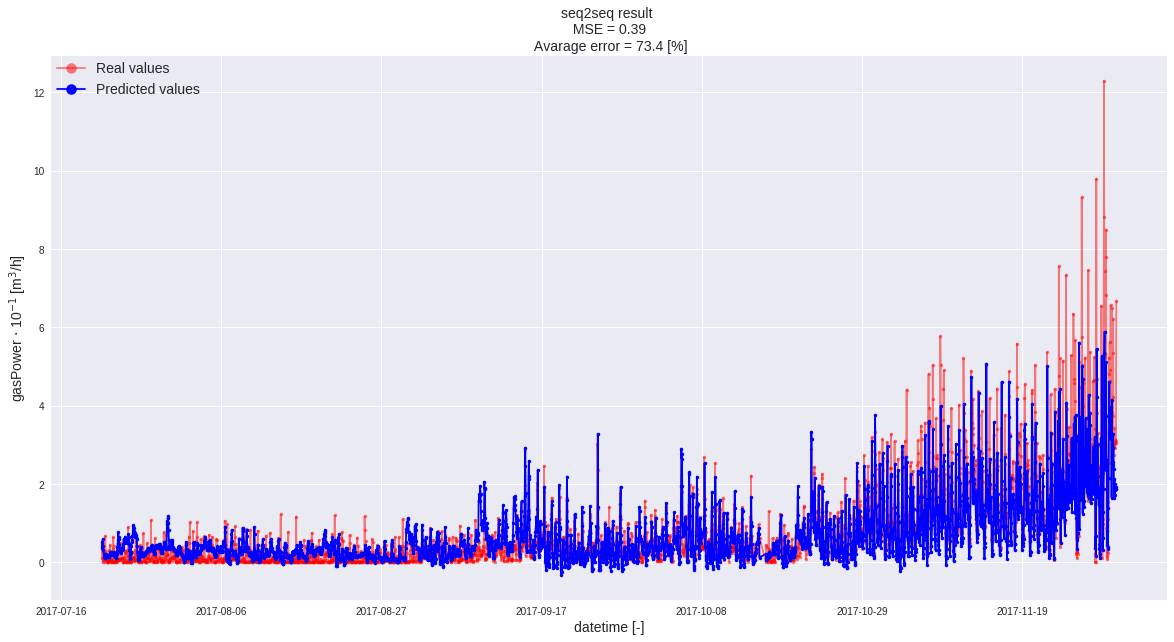

In [114]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='r', label='Real values', alpha=0.5)
plt.plot(x.index, y_preds, '.-', color='b', label='Predicted values')

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[1]
perc = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[2]

plt.title('LSTM result \n MSE = %.2f \n Avarage error = %.1f [%%]' % (mse, perc), fontsize = 14)

plt.savefig('figures/seq2seq result hourly 29-10-2018.png', dpi=1200)
print('FINISHED')